# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
!git clone https://github.com/udacity/RoboND-Segmentation-Lab.git

Cloning into 'RoboND-Segmentation-Lab'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 104 (delta 2), reused 11 (delta 2), pack-reused 93
Receiving objects: 100% (104/104), 35.92 KiB | 2.57 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
import urllib
import os
import glob
import sys
import zipfile
import tensorflow as tf
import keras 
from scipy import misc
import numpy as np
import shutil

from tensorflow.keras import layers, models
from tensorflow import image
from tensorflow.keras.layers import SeparableConv2D, UpSampling2D

In [ ]:
# Copy files into the main working directory
src_path = r"/content/RoboND-Segmentation-Lab/code/utils"
dst_path = r"/content/utils"
shutil.copytree(src_path, dst_path)
src_path = r"/content/RoboND-Segmentation-Lab/data"
dst_path = r"/content/data"
shutil.copytree(src_path, dst_path)

In [9]:
# Download the training data
url_train = "https://s3-us-west-1.amazonaws.com/udacity-robotics/Deep+Learning+Data/Lab/train.zip"
filename_train = "/content/data/train.zip"
urllib.request.urlretrieve(url_train, filename_train)

url_validation = "https://s3-us-west-1.amazonaws.com/udacity-robotics/Deep+Learning+Data/Lab/validation.zip"
filename_validation = "/content/data/validation.zip"
urllib.request.urlretrieve(url_validation, filename_validation)

('/content/data/validation.zip', <http.client.HTTPMessage at 0x7fc5f0b0a510>)

In [10]:
# Unzip the training data 
with zipfile.ZipFile("/content/data/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

# Unzip the Validation data 
with zipfile.ZipFile("/content/data/validation.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

In [14]:
# Put the data folder in the right format for the tensorflow data generators
path_images_train = os.path.join("/content/data/train_combined","images_train")
os.mkdir(path_images_train)
source = "/content/data/train_combined/images"
destination = "/content/data/train_combined/images_train"
shutil.move(source, destination)

path_masks_train = os.path.join("/content/data/train_combined","masks_train")
os.mkdir(path_masks_train)
source = "/content/data/train_combined/masks"
destination = "/content/data/train_combined/masks_train"
shutil.move(source, destination)


path_images_validation = os.path.join("/content/data/validation","images_validation")
os.mkdir(path_images_validation)
source = "/content/data/validation/images"
destination = "/content/data/validation/images_validation"
shutil.move(source, destination)


path_masks_validation = os.path.join("/content/data/validation","masks_validation")
os.mkdir(path_masks_validation)
source = "/content/data/validation/masks"
destination = "/content/data/validation/masks_validation"
shutil.move(source, destination)

'/content/data/validation/masks_validation/masks'

## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will introduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [6]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2D(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [7]:
def bilinear_upsample(input_layer):
    output_layer = UpSampling2D((2,2),interpolation='bilinear')(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [8]:
def encoder_block(input_layer, filters):
    output_layer = conv2d_batchnorm(input_layer, filters, strides=1)
    output_layer = conv2d_batchnorm(output_layer, filters, strides=1)
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the bilinear_upsample() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [9]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_out_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    input_layer = layers.concatenate([large_ip_layer,small_out_layer])
    # TODO Add some number of separable convolution layers
    print(filters)
    output_layer = conv2d_batchnorm(input_layer,filters)
    output_layer = conv2d_batchnorm(output_layer,filters//2)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [13]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32)
    x2 = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(x1)
    print(x1.get_shape())
    print(x2.get_shape())
    x3 = encoder_block(x2,64)
    x4 = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(x3)
    x5 = encoder_block(x4,128)
    x6 = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(x5)
    x7 = encoder_block(x6,256)
    x8 = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(x7)
    print(x3.get_shape())
    print(x4.get_shape())
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x9 = conv2d_batchnorm(x8,512,1)
    x10 = conv2d_batchnorm(x9,256,3)
    print(x5.get_shape())
    print(x6.get_shape())
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x11 = decoder_block(x10,x7,256)
    x12 = decoder_block(x11,x5,128)
    x13 = decoder_block(x12,x3,64)
    x14 = decoder_block(x13,x1,32)
    print(x8.get_shape())
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x14)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [15]:
learning_rate = 0.0001
batch_size = 64
num_epochs = 10
steps_per_epoch = 200
validation_steps = 50
workers = 2

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Train Data generators 
train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
seed = 1
image_generator = train_image_datagen.flow_from_directory('/content/data/train_combined/images_train',target_size=(128,128),class_mode=None,seed=seed)
mask_generator = train_mask_datagen.flow_from_directory('/content/data/train_combined/masks_train',target_size=(128,128),class_mode=None,seed=seed)
train_generator = zip(image_generator, mask_generator)
# Valid Data generators
valid_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
seed = 1
valid_image_generator = valid_image_datagen.flow_from_directory('/content/data/validation/images_validation',target_size=(128,128),class_mode=None,seed=seed)
valid_mask_generator = valid_mask_datagen.flow_from_directory('/content/data/validation/masks_validation',target_size=(128,128),class_mode=None,seed=seed)

# Zip the image and mask generators 
train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_image_generator,valid_mask_generator)

# model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.summary()

# Fit the Model 
history = model.fit(train_generator, epochs = num_epochs,validation_data=valid_generator,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,workers=workers)

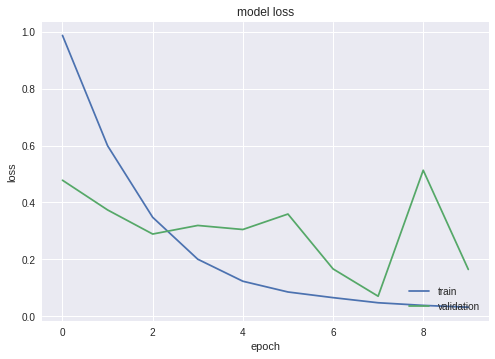

In [ ]:
import pickle 
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
model.save('/content/data/weights/first_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = tf.keras.models.load_model('/content/data/weights/first_model.h5')


## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

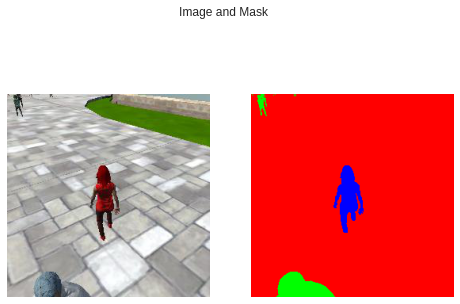

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import random
from glob import glob


# Create a list of images and sort them
path_image = os.path.join('/content','data','validation','images_validation','images')
os.chdir(path_image)
image_filenames = glob("*.jpeg")
image_filenames.sort()

# Create a list of masks and sort them 
path_mask = os.path.join('/content','data','validation','masks_validation','masks')
os.chdir(path_mask)
mask_filenames = glob("*.png")
mask_filenames.sort()

# import a random image along with its mask 
rand = random.randint(0,len(image_filenames)-1)
image = mpimg.imread(os.path.join(path_image,image_filenames[rand]))
mask = mpimg.imread(os.path.join(path_mask,mask_filenames[rand]))

# plot them 
fig, axs = plt.subplots(1,2)
fig.suptitle('Image and Mask')
axs[0].imshow(image)
axs[1].imshow(mask)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

the image has now shape: (1, 128, 128, 3)  and is ready to get into our model


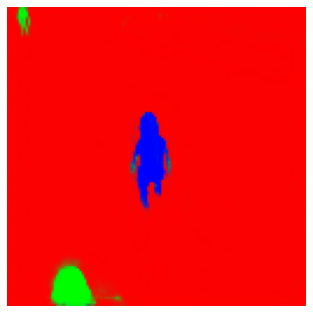

In [ ]:
# Let's preprocess the prediction image.
image = image/255.0
image = cv2.resize(image,(128,128))
image = np.expand_dims(image,0)
print("the image has now shape:",image.shape, " and is ready to get into our model")
# predict the image mask
mask = model.predict(image)
plt.imshow(mask[0])
plt.axis('off')
plt.show()